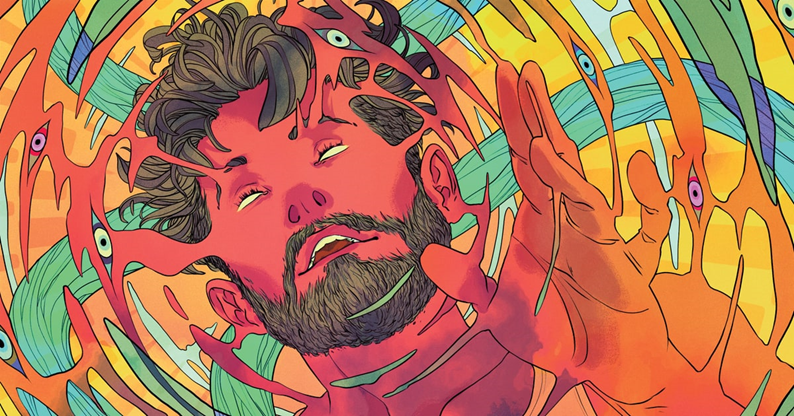

# The Erowid Corpus: A textual analysis

## Ian Goodrich, 
### Master of Arts in Applied Public Policy candidate, School of Public Policy, Central European University

In [1]:
import re
import pandas as pd
from pandas.io.json import json_normalize

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

stop_words = set(stopwords.words('english'))
wnl = WordNetLemmatizer()

sia = SIA()

from collections import Counter


C:\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Initial Import
Importing the raw data, taken from [Erowid Reports by Matti Vuorre (2016)](Erowid Reports
Matti Vuorre), available on GitHub. This dataset excludes a couple of key fields (specifically categories, intensity and drug-type), which I also import from a scrape I've undertaken.

In [2]:
df = pd.read_csv('erowid_from_rda.csv', encoding = "ISO-8859-1")
cats = pd.read_csv('categories.csv')
cats = cats.drop(columns = "Unnamed: 0")
subs = pd.read_csv('substance.csv', names = ['drop', 'Category', 'ID'], header = 0)
subs = subs.drop(columns = "drop")
sub_cats = pd.read_csv('sub_cats.csv', names = ['substance', 'other_names', 'category'], header = 0)

In [3]:
## A quick count of categories reported from the scraped file. NB: Plenty, if not all reports fall into multiple categories.
cats_count = cats.Category.value_counts()
subs_count = subs.Category.value_counts()
cats_count.to_csv('cats_count.csv')
subs_count.to_csv('cats_count.csv')

In [4]:
## Filling NaN, was going to use this for something later, but I've not bothered in the end. Kept as it's the way I've structured
## the next bit
sub_cats.fillna("", inplace = True)

## A load of items at the end of category list (and a few scattered about, but they'll probably get lost in a trim later)
## are non-drug substances, so I'm making them as such.
sub_cats['category'].loc[754:] = "Non Drug"

## And count 'em
sub_cats_count = sub_cats['category'].value_counts()

## I make lists of names of categories, other names and substances
all_sub_cats = list(sub_cats['category'].unique())
all_subs = list(sub_cats['substance'].unique())
all_other = list(sub_cats['other_names'].unique())
all_cats = list(sub_cats['substance'][(sub_cats['substance'].isin(sub_cats['category'])) & (sub_cats['category'] =="")])

gotta_catch_em_all = ['acid', 'mushroom', 'ecstasy', 'marijuana']
all_everything = all_subs + all_other + gotta_catch_em_all

# I make a list of substances so I can strip them out.
subs_list = [str(x).lower().strip() for x in all_everything]

## I merge the categories into the main dataframe as a list
for frame in [cats, subs]:
    frame = frame.groupby(by = "ID")['Category'].agg(lambda x: [x for x in x])
    frame = frame.reset_index()
    df = df.merge(frame, left_on = 'id', right_on = 'ID')
    
## Drop a few useless columns, rename the merged ones, and set the index
df = df.drop(columns=["Unnamed: 0", "dosechart", "ID_x", "ID_y", "substance"])\
            .rename(columns={'Category_x': 'category', 'Category_y': 'substance'})\
            .set_index('id')

## These three lines nearly drove me mad. My problem was that the data I merged with substances often contained both substance and
## category (e.g. stimulants and MDMA). This wasn't particularly useful for analysis. What this does is create a new column for
## categories ('sub_cats'), then create a new 'substance' column with everything that's not in there.

## The problem with this approach was that it skipped a few substances that were both substances and categories (e.g. cannabis). 
## As a crude work-around, I've filled blanks that this created, now come to think of it, this may ignore some stuff, but got I need
## to get on with my life. Too long spent on a few lines of code!

df['sub_cats'] = df['substance'].apply(lambda x: [i for i in x if i in all_cats])
df['substance_'] = df['substance'].apply(lambda x: [i for i in x if i not in all_cats])
df['substance'] = df['substance'].where(df['substance_'].str.len() == 0, df['substance_'])

df = df.drop(columns = 'substance_')
df['num_subs'] = df['substance'].str.len()

In [5]:
# df = df[df['num_subs'] == 1]
df['substance'] = df['substance'].apply(lambda x: x[0] if (len(x) > 0 ) else x)
df['sub_cats'] = df['sub_cats'].apply(lambda x: x[0] if (len(x) > 0 ) else x)
df['sub_cats'] = df['substance'].where(df['sub_cats'].str.len() == 0, df['sub_cats'])

In [6]:
## I sort them into positive and negative experiences. I've counted Glowing and Mystical as positive, and Difficult, Bad and
## "Train Wrecks" as bad. This is a little subjective, but I wanted as many records as possible in one or the other category.
## Interestingly, there are nearly 400 reports which are in both, even when reducing down to "Train Wrecks" and "Glowing" only
## we still get a little overlap. I can live with this, and should really read those ones.

positive = ['Glowing Experiences', 'Mystical Experiences']
negative = ['Difficult Experiences', 'Bad Trips', 'Train Wrecks & Trip Disasters']

def toner(x):
    pos = bool([True for i in x if i in positive])
    neg = bool([True for i in x if i in negative])
    mix = bool(pos and neg)
    
    if mix:
        return "Not Specified"  ## It's easier for me to only have three categories, so I'll throw these back on the heap.
    elif pos and not neg:
        return "Positive"
    elif neg and not pos:
        return "Negative"
    else:
        return "Not Specified"

df['tone'] = df['category'].apply(lambda x: toner(x))





In [7]:
## Stripping out some junk from the text
df['text'] = df['text'].apply(lambda x: re.sub(r'<span class="erowid-warning">[\S\s]+</[\S\s]+>', "", str(x)))
df['text'] = df['text'].apply(lambda x: re.sub(r'<[^!]+>', "", str(x)))
df['text'] = df['text'].apply(lambda x: re.sub(r".#x..", "", str(x)))

In [8]:
## I POS tag first for better lemmatisation. This bit of code was pulled wholesale from here: 
## https://rustyonrampage.github.io/text-mining/2017/11/23/stemming-and-lemmatization-with-python-and-nltk.html


def get_pos(word):
    w_synsets = wordnet.synsets(word)

    pos_counts = Counter()
    pos_counts["n"] = len(  [ item for item in w_synsets if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in w_synsets if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in w_synsets if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in w_synsets if item.pos()=="r"]  )
    
    most_common_pos_list = pos_counts.most_common(3)
    return most_common_pos_list[0][0]

## I'm going to make a very clean version of the word_sent, which strips out stopwords, punctuation, numbers and the names of
## substances, then lemmatises to find the roots of words. 

def clean_word_f(x):
    out = []
    x = word_tokenize(x.lower())
    for i in x:
        i = i.strip("'")
        if i not in stop_words and i not in subs_list and re.match(r'[a-z]', i) and len(i) >2:
            out.append(wnl.lemmatize(i, get_pos(i)))
    return out

## Tokenising at word and sentance level
df['token_sent'] = df['text'].apply(lambda x: sent_tokenize(x.lower()))
df['word_clean'] = df['text'].apply(lambda x: clean_word_f(x))


In [9]:
df['vader_whole'] = df['text'].apply(lambda x: sia.polarity_scores(x))
df['vader_clean'] = df['word_clean'].apply(lambda x: sia.polarity_scores(" ".join(x)))

In [10]:
df = pd.concat([df.drop(['vader_whole'], axis=1), df['vader_whole'].apply(pd.Series)], axis=1)
df = df.rename(columns = {'neg' : 'vw_neg', 'neu' : 'vw_neu', 'pos' : 'vw_pos', 'compound' : 'vw_compound'})
df = pd.concat([df.drop(['vader_clean'], axis=1), df['vader_clean'].apply(pd.Series)], axis=1)
df = df.rename(columns = {'neg' : 'vc_neg', 'neu' : 'vc_neu', 'pos' : 'vc_pos', 'compound' : 'vc_compound'})

In [11]:
def sent_vader(x):
    out = []
    out_dict = {}
    for i in x:
        out.append(sia.polarity_scores(i))
    
    return out
df['vader_sent'] = df['word_clean'].apply(lambda x: sent_vader(x))


In [12]:
def categorise_sent(x):
    if x > 0:
        return "Positive"
    else:
        return "Negative"

# for i in vader_compound:
#     head = str(i)[:3]
#     h_tone = head + "tone"
#     h_acc = head + "acc"
#     df[h_tone] = df[i].apply(lambda x: vader_compound(x))
#     df[h_acc] = df[h_tone] == df["Tone"]
df["vc_pred"] = df["vc_compound"].apply(lambda x: categorise_sent(x))
df["vw_pred"] = df["vw_compound"].apply(lambda x: categorise_sent(x))
# df["vs_pred"] = df["vs_compound"].apply(lambda x: categorise_sent(x))

df["vc_acc"] = df["vc_pred"] == df["tone"]
df["vw_acc"] = df["vw_pred"] == df["tone"]
# df["vs_acc"] = df["vs_pred"] == df["tone"]

vc_tab = df["vc_acc"][df['tone'].isin(['Positive', 'Negative'])].value_counts()
vw_tab = df["vw_acc"][df['tone'].isin(['Positive', 'Negative'])].value_counts()
# vw_tab = df["vs_acc"][df['tone'].isin(['Positive', 'Negative'])].value_counts()


In [ ]:
# df['tone'].value_counts()
df.to_csv('erowid_processed.csv')